# Credit Card Fraud Detection

 The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.

### Objetivo do Case
 
Intenção do presente Case, é apresentar 2 modelos que sejam capazes de prever um novo caso de fraude.

Os modelos escolhidos consistem:
    
    Modelo de Árvore de Decisões (Classificação)
    
    Modelo: Regressão Logística
    
Devido a natureza da variável de interesse 'Class' que classifica se a operação é uma fraude ou não (0 e 1), utilizamos tal modelo para a construção do case.





## Rodando os pacotes Necessários

In [87]:
import sklearn as sk
import numpy as np
import pandas as pd
import os as os
import random
from random import sample
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import cross_validate

Descobrindo o caminho do arquivo

In [ ]:
caminho = os.getcwd()
print(caminho)

Interpretando a base de dados

In [85]:

base = pd.read_csv('creditcard.csv', sep = ',')
base.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
#rodando informações do summary
base.describe()
print(base.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


# Plotando as distribuições das Features

C:\Users\vinic\AppData\Local\Temp/ipykernel_9400/2719385790.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


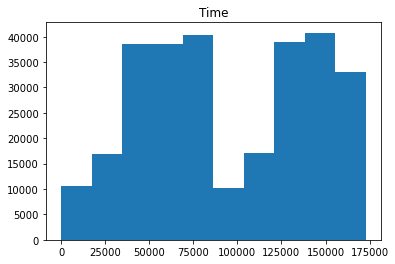

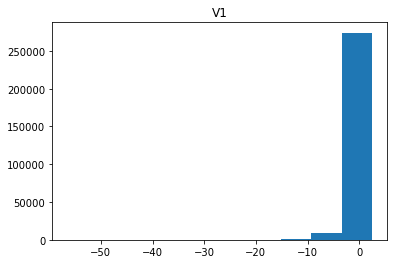

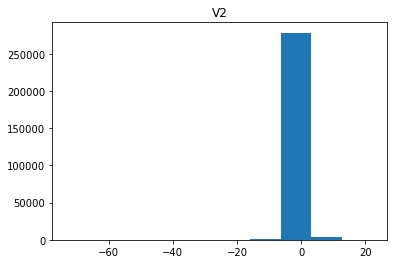

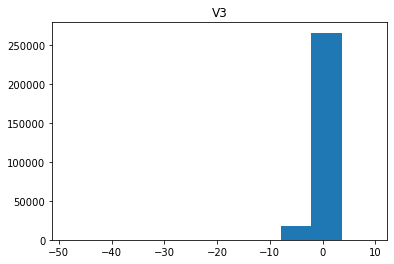

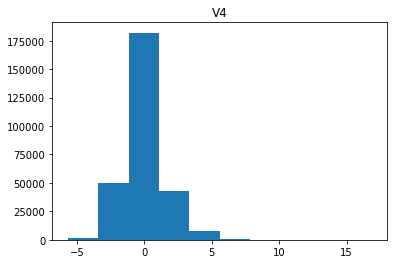

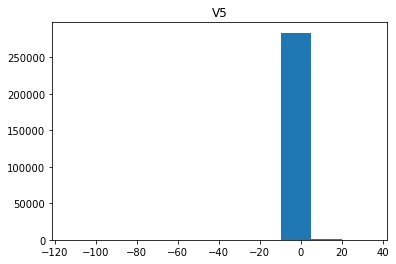

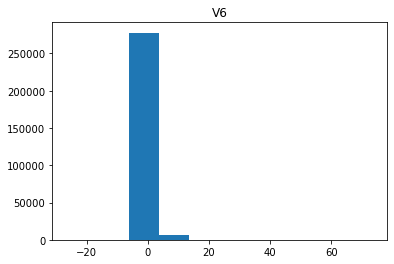

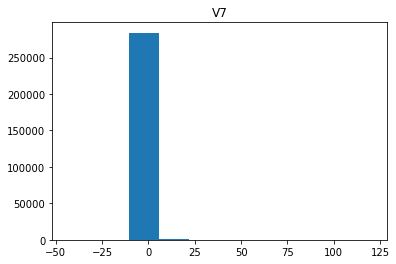

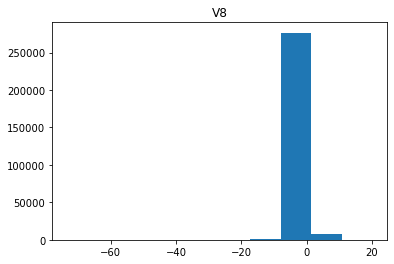

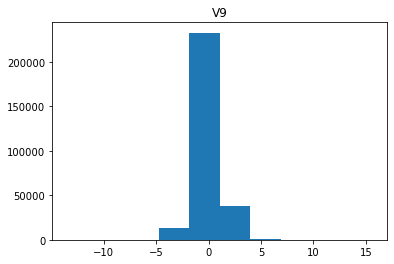

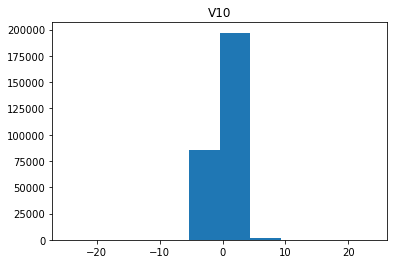

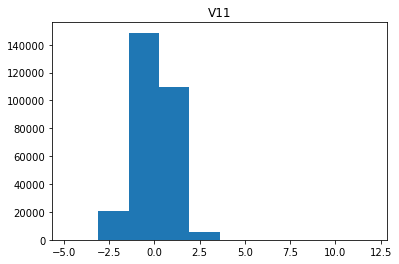

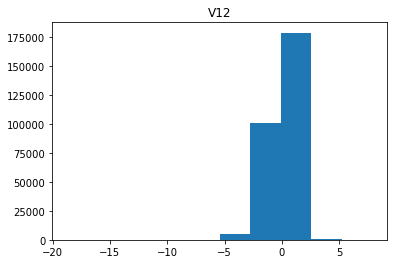

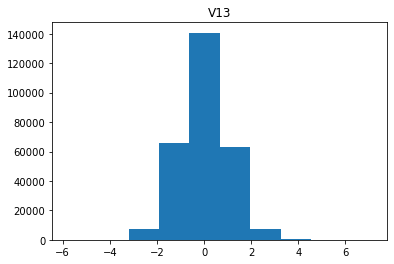

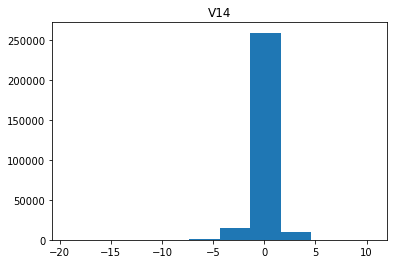

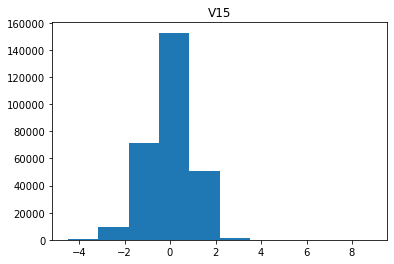

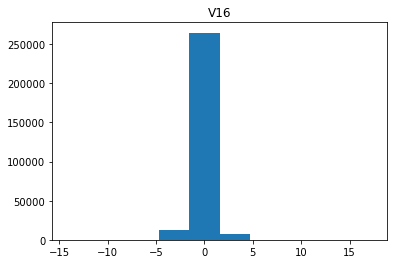

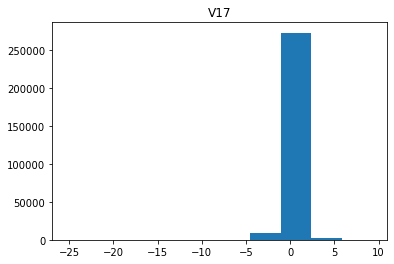

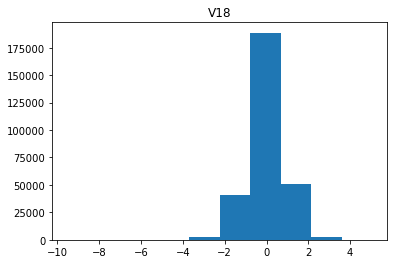

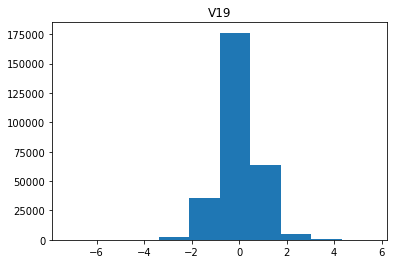

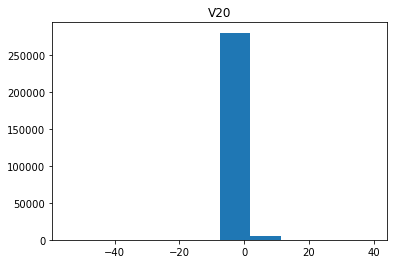

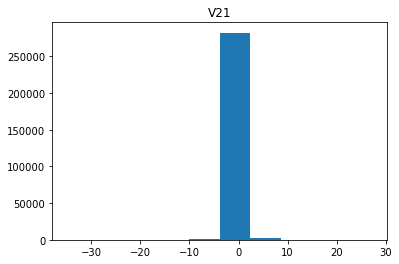

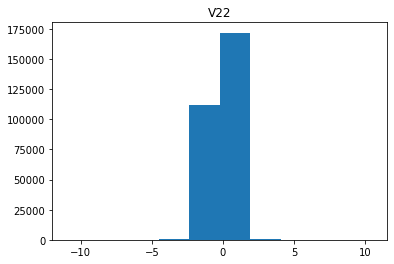

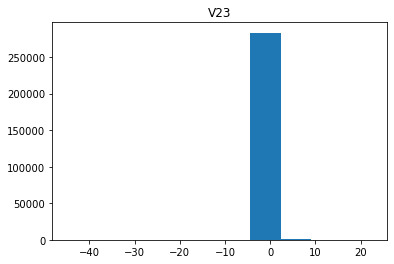

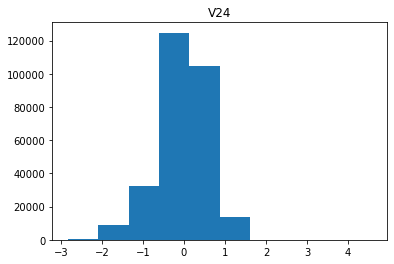

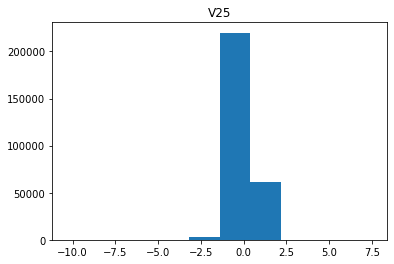

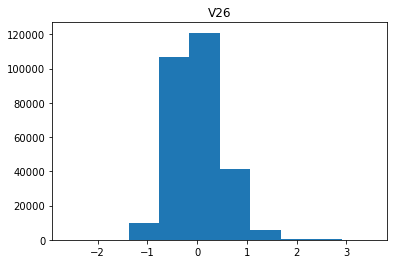

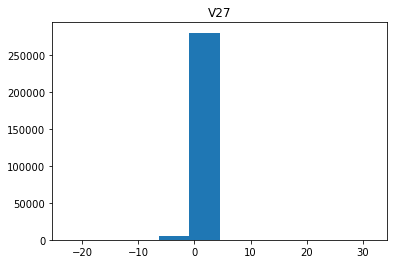

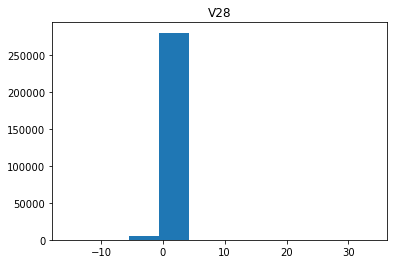

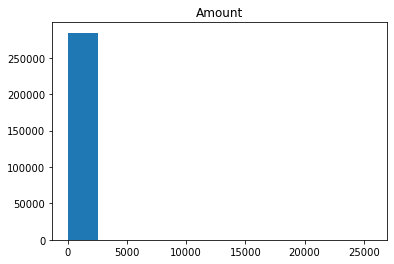

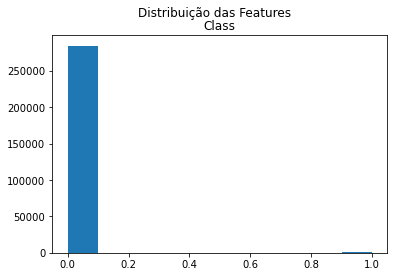

In [127]:
for i in base.columns:
    plt.figure()
    plt.title(f'{i}')
    plt.hist(base[i])
plt.suptitle('Distribuição das Features')
plt.show()

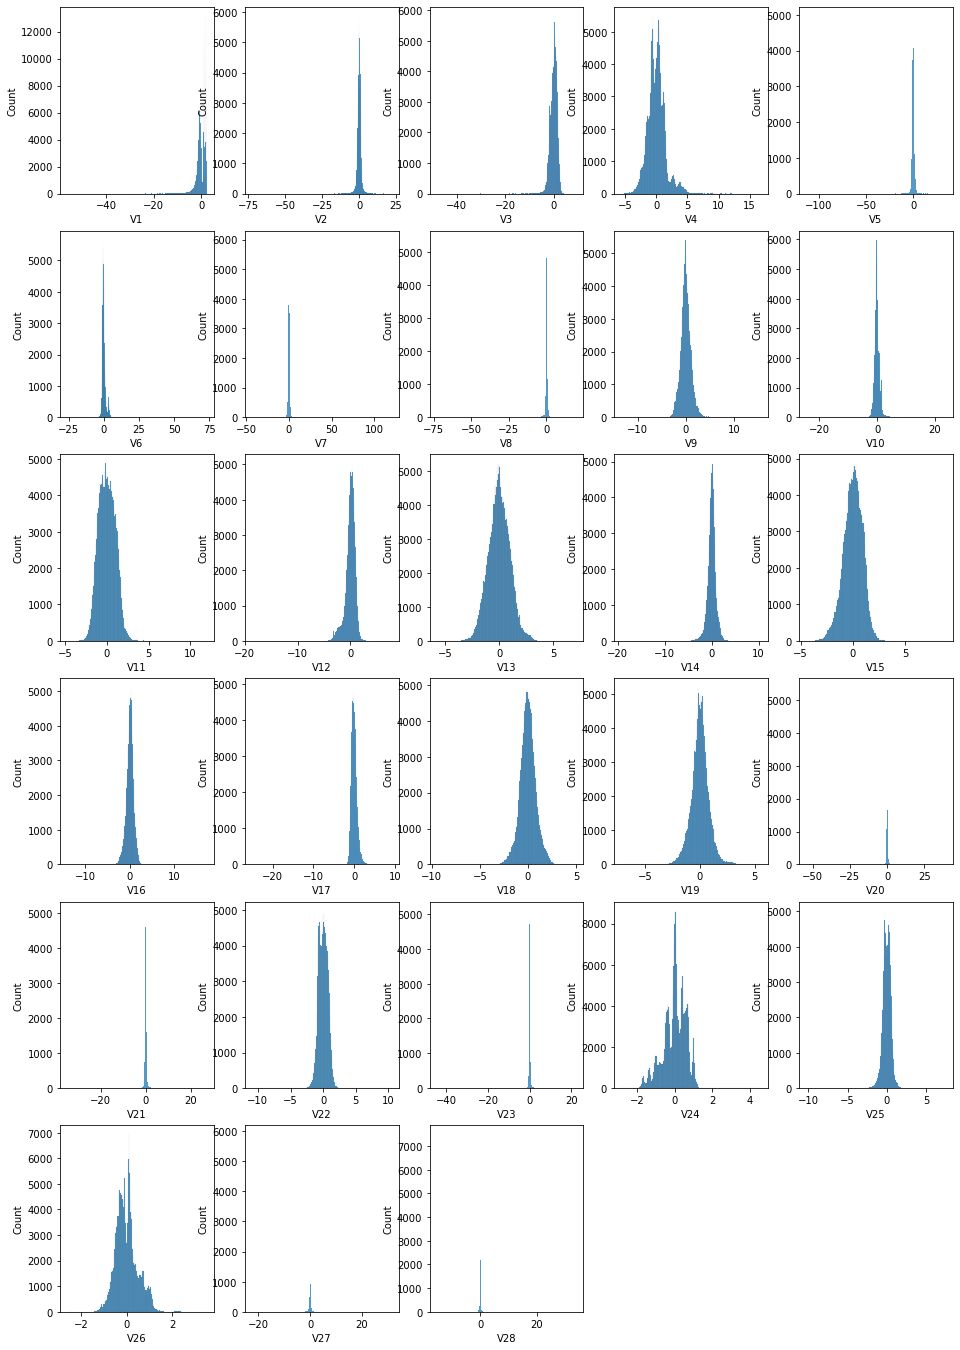

In [129]:
plt.figure(figsize=(16,24))
numRange= [i for i in range(1,29)]
for i in numRange:
    plt.subplot(6,5,i,aspect='auto')
    indice = 'V'+str(i)
    sns.histplot(base,x=indice)

# Rodando um VIF para compreender a Multicolinearidade dos dados em relação com a resposta

A ideia é conseguir distinguir quais features vamos utilizar para o modelo de árvore de decisão

In [9]:
def calculate_vif(dataset):
    vif = pd.DataFrame()
    vif['features'] = dataset.columns
    vif['VIF_Value'] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    
    return(vif)

In [10]:
features = base.iloc[:,:-1]
print(calculate_vif(features))

   features  VIF_Value
0      Time   2.339084
1        V1   1.621694
2        V2   3.869377
3        V3   1.255585
4        V4   1.137944
5        V5   2.753075
6        V6   1.522122
7        V7   2.510165
8        V8   1.097151
9        V9   1.018831
10      V10   1.115668
11      V11   1.028861
12      V12   1.011961
13      V13   1.003434
14      V14   1.026832
15      V15   1.014135
16      V16   1.000371
17      V17   1.004772
18      V18   1.006568
19      V19   1.037809
20      V20   2.233934
21      V21   1.100720
22      V22   1.082384
23      V23   1.149268
24      V24   1.000659
25      V25   1.013388
26      V26   1.000487
27      V27   1.008979
28      V28   1.001425
29   Amount  11.499791


# Utilizando a correlação de Pearson devido a escala intervalar dos dados afim de excluir variáveis com as mesmas informações

In [11]:
# Utilizando Spearman devido a não Normalidade da resposta.
corr = base.corr(method = 'spearman')
corr.style.background_gradient(cmap='coolwarm')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,0.190647,-0.006419,-0.473348,-0.142156,0.226004,-0.111408,0.116722,-0.103882,0.017986,0.014692,-0.227116,0.073665,-0.045340,-0.092388,-0.205421,0.002415,-0.102351,0.090840,0.025136,-0.120319,0.096564,0.132651,0.148505,-0.015980,-0.259220,0.000132,-0.035063,-0.143200,-0.040007,-0.011692
V1,0.190647,1.000000,-0.384328,-0.412095,0.101011,-0.106632,-0.086561,-0.227650,-0.236140,0.138614,0.231636,0.013750,0.003095,0.047839,-0.024329,0.030048,0.037791,-0.057902,-0.043565,0.031168,-0.209614,-0.061958,-0.028827,0.145440,-0.000315,0.049291,0.006380,-0.104815,-0.207967,-0.086663,-0.042424
V2,-0.006419,-0.384328,1.000000,0.073967,0.155042,0.342701,-0.110393,0.426320,0.006980,-0.077880,-0.212437,-0.013464,0.052846,0.028702,0.088108,0.038186,0.068053,-0.002416,0.011481,0.002082,0.040716,-0.098255,-0.056478,-0.094982,0.012617,-0.085682,0.033865,0.129234,0.137976,-0.502052,0.051062
V3,-0.473348,-0.412095,0.073967,1.000000,0.060812,-0.223849,0.171263,-0.074582,0.164374,-0.030876,-0.070960,0.056105,-0.051875,0.006839,-0.130565,0.051314,-0.046590,-0.035420,-0.045167,-0.015326,0.108271,-0.040234,0.004404,-0.140076,-0.000559,0.031854,-0.016689,0.140724,0.180169,-0.000236,-0.059278
V4,-0.142156,0.101011,0.155042,0.060812,1.000000,0.021367,0.075185,0.059920,-0.009608,0.105248,0.025553,-0.013122,0.147738,-0.024538,0.099464,0.053405,-0.041414,0.049298,0.021175,-0.017866,-0.009598,0.038960,-0.004931,0.009615,-0.008782,0.060647,-0.064357,-0.033634,0.004757,-0.022117,0.063045
V5,0.226004,-0.106632,0.342701,-0.223849,0.021367,1.000000,-0.007577,0.431573,-0.057022,-0.056580,-0.154910,0.010749,-0.048560,0.019549,0.035107,-0.041029,-0.007564,-0.145735,-0.016252,0.012257,0.056719,-0.040364,-0.010920,-0.108300,-0.023076,-0.015618,0.029513,0.012883,-0.027806,-0.314061,-0.030147
V6,-0.111408,-0.086561,-0.110393,0.171263,0.075185,-0.007577,1.000000,-0.292680,0.444053,0.028864,0.063326,0.059672,0.037176,-0.004068,-0.068788,-0.046259,-0.020208,-0.027470,0.052293,0.031965,0.052824,0.034595,0.040370,-0.050293,-0.135166,-0.011131,-0.023932,0.073772,0.020459,0.205452,-0.038410
V7,0.116722,-0.227650,0.426320,-0.074582,0.059920,0.431573,-0.292680,1.000000,-0.389213,-0.100252,-0.207930,0.003714,-0.043924,-0.015749,0.058462,-0.051186,-0.120372,-0.147005,-0.070876,0.000808,0.160522,-0.022250,-0.023750,-0.186343,-0.012879,-0.046468,0.016724,-0.094494,0.056405,-0.030003,-0.048308
V8,-0.103882,-0.236140,0.006980,0.164374,-0.009608,-0.057022,0.444053,-0.389213,1.000000,-0.002511,-0.120992,0.053048,0.106016,-0.144864,0.041255,-0.016752,0.089504,0.074985,0.066508,-0.033248,0.006028,0.076569,0.019775,0.075212,-0.024536,-0.074303,-0.007648,0.189916,0.089700,0.004371,0.022706
V9,0.017986,0.138614,-0.077880,-0.030876,0.105248,-0.056580,0.028864,-0.100252,-0.002511,1.000000,-0.291153,-0.031365,0.103193,-0.047521,-0.031144,-0.004438,-0.031735,-0.068576,-0.014809,0.003057,-0.015357,-0.065773,0.001958,0.074164,-0.001572,-0.022575,0.026677,-0.001804,-0.103743,-0.077437,-0.049499


# Obtendo as features que podem ser incluídas no modelo

Optei por utilizar o feature selector Boruta

Devido a sintaxe do Boruta exigir array's do DataFrame, fazemos as modificações abaixo:

In [71]:
#x = base[['V1']].to_numpy()
#y = base[['Class']].to_numpy()

X_treino = base.drop(['Class'], axis = 1).to_numpy()
y_treino = base.Class.to_numpy()

X = base.drop(['Class'], axis =1)



# Algoritmo Boruta

## Porque utilizar o Boruta?

Boruta é um selecionador de features para a criação dos modelos

In [ ]:
###initialize Boruta
forest = RandomForestClassifier()
boruta = BorutaPy(
   estimator = forest,
    n_estimators = 10,
   max_iter = 5 # number of trials to perform
)

In [63]:
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(X_treino, y_treino)

BorutaPy(estimator=RandomForestClassifier(n_estimators=10,
                                          random_state=RandomState(MT19937) at 0x2834BB89E40),
         max_iter=5, n_estimators=10,
         random_state=RandomState(MT19937) at 0x2834BB89E40)

In [69]:
### print results
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()

In [77]:
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: []
features in the blue area: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V18', 'V20', 'V21', 'V22', 'V26', 'V27', 'Amount']


# Retirar dos dados as features que não foram apresentadas no Boruta

In [96]:
db = base.drop(['V15','V23','V24','V25','V28','Class'], axis =1)
y_db = base['Class']

Transformando as variáveis abaixo em Array's para entrar no Cross Validation

In [91]:
X_validacao = db.to_numpy()
y_validacao = y_db.to_numpy()

print(X_validacao)
print(y_validacao)

[[ 0.00000000e+00 -1.35980713e+00 -7.27811733e-02 ... -1.89114844e-01
   1.33558377e-01  1.49620000e+02]
 [ 0.00000000e+00  1.19185711e+00  2.66150712e-01 ...  1.25894532e-01
  -8.98309914e-03  2.69000000e+00]
 [ 1.00000000e+00 -1.35835406e+00 -1.34016307e+00 ... -1.39096572e-01
  -5.53527940e-02  3.78660000e+02]
 ...
 [ 1.72788000e+05  1.91956501e+00 -3.01253846e-01 ... -8.73705959e-02
   4.45477214e-03  6.78800000e+01]
 [ 1.72788000e+05 -2.40440050e-01  5.30482513e-01 ...  5.46668462e-01
   1.08820735e-01  1.00000000e+01]
 [ 1.72792000e+05 -5.33412522e-01 -1.89733337e-01 ... -8.18267121e-01
  -2.41530880e-03  2.17000000e+02]]
[0 0 0 ... 0 0 0]


# Validação K-Fold

### Vamos utilizar o modelo de árvore de decisão inicialmente

In [76]:
clf = tree.DecisionTreeClassifier()

Vamos utilizar a função custo 'Recall' devido a necessidade de valorizar os casos Falsos Negativos.

Abaixo, segue as modificações utilizadas para adaptar os códigos da função.

Tais funções foram adaptadas Iniabasi Affiah, no site: https://www.section.io/engineering-education/how-to-implement-k-fold-cross-validation/

### Através da modificação abaixo, é possível obter a expressão das funções custo, Acurácia, Precisão, F1_score e Recall.

In [94]:
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [131]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

# Rodando o K-Fold

Através das funções que foram modificadas acima, contextualizadas, vamos utilizar as modificações feitas anteriormente nas variáveis para desenvolver a validação cruzada e obter a função custo

In [137]:
Val = cross_validation(clf,X_validacao, y_validacao, _cv=5)
print(Val)

#Manaus isso aqui ta bom?

#Plotei os gráficos das normais pra ver como se distribuem

{'Training Accuracy scores': array([1., 1., 1., 1., 1.]), 'Mean Training Accuracy': 100.0, 'Training Precision scores': array([1., 1., 1., 1., 1.]), 'Mean Training Precision': 1.0, 'Training Recall scores': array([1., 1., 1., 1., 1.]), 'Mean Training Recall': 1.0, 'Training F1 scores': array([1., 1., 1., 1., 1.]), 'Mean Training F1 Score': 1.0, 'Validation Accuracy scores': array([0.00617956, 0.99940311, 0.9961026 , 0.99831464, 0.99885887]), 'Mean Validation Accuracy': 79.97717540679793, 'Validation Precision scores': array([0.0016403 , 0.91139241, 0.26335878, 0.50833333, 0.68131868]), 'Mean Validation Precision': 0.47320869935394966, 'Validation Recall scores': array([0.93939394, 0.72727273, 0.70408163, 0.62244898, 0.63265306]), 'Mean Validation Recall': 0.725170068027211, 'Validation F1 scores': array([0.00327488, 0.80898876, 0.38333333, 0.55963303, 0.65608466]), 'Mean Validation F1 Score': 0.48226293189968805}


### Plotando o Recall referente ao training e Validação do K-FOLD

Podemos notar um grande indicativo de Overfit do Modelo

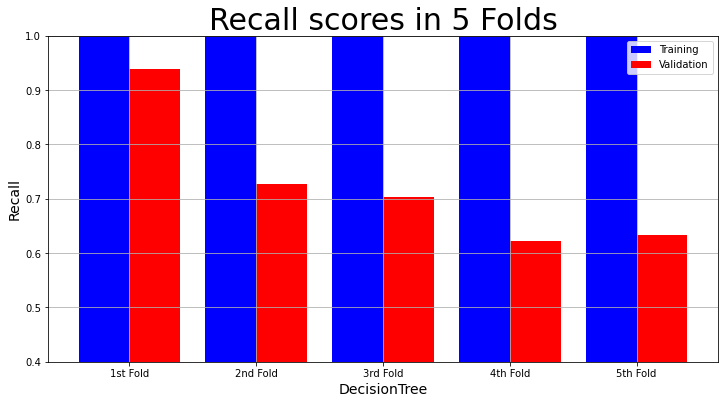

[0.93939394 0.72727273 0.70408163 0.62244898 0.63265306]


In [146]:
model_name = 'DecisionTree'
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            Val["Training Recall scores"],
            Val["Validation Recall scores"])
print(Val["Validation Recall scores"])

In [142]:
Decision2 = tree.DecisionTreeClassifier(criterion="entropy",
                                               min_samples_split=5,
                                               random_state=0)
Val2 = cross_validation(clf,X_validacao, y_validacao, _cv=5)
print(decision_tree_result_2)

{'Training Accuracy scores': array([1., 1., 1., 1., 1.]), 'Mean Training Accuracy': 100.0, 'Training Precision scores': array([1., 1., 1., 1., 1.]), 'Mean Training Precision': 1.0, 'Training Recall scores': array([1., 1., 1., 1., 1.]), 'Mean Training Recall': 1.0, 'Training F1 scores': array([1., 1., 1., 1., 1.]), 'Mean Training F1 Score': 1.0, 'Validation Accuracy scores': array([0.00617956, 0.99928022, 0.99664683, 0.99840242, 0.99885887]), 'Mean Validation Accuracy': 79.9873578554519, 'Validation Precision scores': array([0.00162272, 0.8625    , 0.29694323, 0.53153153, 0.68131868]), 'Mean Validation Precision': 0.47478323246879983, 'Validation Recall scores': array([0.92929293, 0.6969697 , 0.69387755, 0.60204082, 0.63265306]), 'Mean Validation Recall': 0.7109668109668109, 'Validation F1 scores': array([0.00323978, 0.77094972, 0.41590214, 0.5645933 , 0.65608466]), 'Mean Validation F1 Score': 0.4821539195426231}


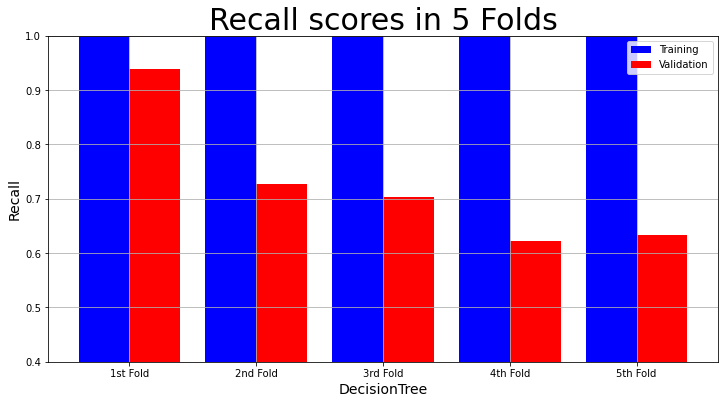

[0.93939394 0.72727273 0.70408163 0.62244898 0.63265306]


In [145]:
model_name = 'DecisionTree'
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            Val["Training Recall scores"],
            Val["Validation Recall scores"])

print(Val['Validation Recall scores'])

# Resolvendo o problema de Overfit do Modelo de Arvore de decisão